<a href="https://www.kaggle.com/code/ishmaelgarcia/assignment-2?scriptVersionId=102950954" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/assignment2/sample_submission.csv
/kaggle/input/assignment2/eval.csv
/kaggle/input/assignment2/train.csv


# Load csv files

In [2]:
train = pd.read_csv('/kaggle/input/assignment2/train.csv')
print(train.shape)
test = pd.read_csv('/kaggle/input/assignment2/eval.csv')
train.info()

(1421, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1421 non-null   int64 
 1   title                     1421 non-null   object
 2   console                   1421 non-null   int64 
 3   alcohol_reference         1421 non-null   int64 
 4   animated_blood            1421 non-null   int64 
 5   blood                     1421 non-null   int64 
 6   blood_and_gore            1421 non-null   int64 
 7   cartoon_violence          1421 non-null   int64 
 8   crude_humor               1421 non-null   int64 
 9   drug_reference            1421 non-null   int64 
 10  fantasy_violence          1421 non-null   int64 
 11  intense_violence          1421 non-null   int64 
 12  language                  1421 non-null   int64 
 13  lyrics                    1421 non-null   int64 
 14  mature_humor 

**Lets print the head to see the columns and info we have**

In [3]:
train['esrb_rating'].value_counts()

T     510
ET    321
E     297
M     293
Name: esrb_rating, dtype: int64

<AxesSubplot:xlabel='esrb_rating', ylabel='count'>

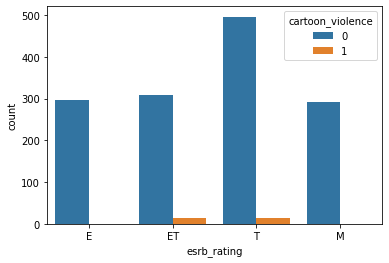

In [4]:
sns.countplot(data = train, x = 'esrb_rating', hue = 'cartoon_violence')

In [5]:
print(train['esrb_rating'].unique())
train.head()

['E' 'ET' 'T' 'M']


,id,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,474,Road to Ballhalla,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,475,RollerCoaster Legends II: Thor's Hammer,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ET
2,476,Island Time,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ET
3,477,Bridge Constructor Portal,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ET
4,478,Secret of Mana,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ET


* So we see we have game titles and categories these games fall into. 1 - yes or 0 - no. 

* We also see there is a console column i'm assuming is just checking if this game title is available on console. There is no correlation and I believe does not affect the rating of the game itself in any way.

* id, title, and console columns will be dropped as they dont predict rating

* Since its categorical data we can assume there are no outliers

* Above we can confirm there are no null values so no filling or deleting is necessary

<AxesSubplot:xlabel='esrb_rating', ylabel='count'>

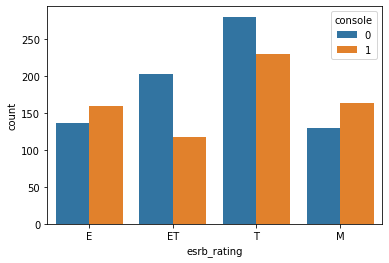

In [6]:
sns.countplot(data = train, x = 'esrb_rating', hue = 'console')

* When printing the all the columns we notice columns that share similar key words. Examples: "mild" , "strong", "sexual", "Blood", "Alcohol", "Drugs", "Violence"

* Lets create new columns to indicate if there is at least 1 feature with these keywords then drop other columns. This will decrease our columns making the data more concise

* Below we see mild steadily increases mostly in the middle "ET" and "T" ratings with mild not really associated with "M" rated games

<AxesSubplot:xlabel='esrb_rating', ylabel='count'>

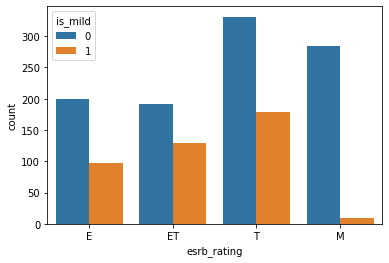

In [7]:
train['is_mild'] = train.mild_cartoon_violence | train.mild_fantasy_violence | train.mild_language | train.mild_blood | train.mild_lyrics | train.mild_suggestive_themes | train.mild_violence
test['is_mild'] = test.mild_blood | test.mild_cartoon_violence | test.mild_fantasy_violence | test.mild_language | test.mild_lyrics | test.mild_suggestive_themes | test.mild_violence
sns.countplot(data = train, x = 'esrb_rating', hue = 'is_mild')

* Here we see "strong" is heavily associated to "M" rated games

<AxesSubplot:xlabel='esrb_rating', ylabel='count'>

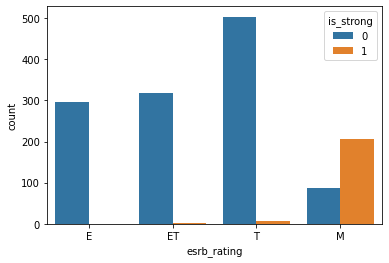

In [8]:
train['is_strong'] = train.strong_janguage | train.strong_sexual_content
test['is_strong'] = test.strong_janguage | test.strong_sexual_content
sns.countplot(data = train, x = 'esrb_rating', hue = 'is_strong')

* Now that we have grouped violent keyword we see lots of "E" and "T" ratings but also "M" and the least is "E". We might have to make another column to be a little bit more specific such as "violent" and "bloody/gore". For now this will do

<AxesSubplot:xlabel='esrb_rating', ylabel='count'>

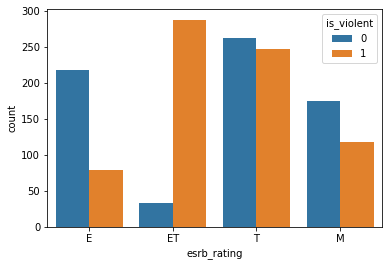

In [9]:
train['is_violent'] = train.fantasy_violence | train.violence | train.intense_violence | train.mild_cartoon_violence | train.mild_fantasy_violence | train.mild_violence | train.cartoon_violence
test['is_violent'] = test.fantasy_violence | test.violence | test.intense_violence | test.mild_cartoon_violence | test.mild_fantasy_violence | test.mild_violence | test.cartoon_violence
sns.countplot(data = train, x = 'esrb_rating', hue = 'is_violent')

* Lets just compact any column with the mention of a drug

<AxesSubplot:xlabel='esrb_rating', ylabel='count'>

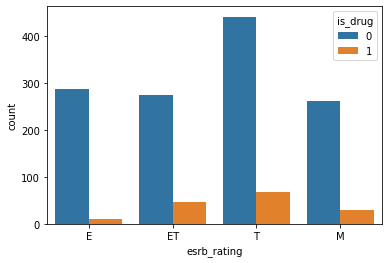

In [10]:
train['is_drug'] = train.use_of_drugs_and_alcohol | train.use_of_alcohol | train.alcohol_reference | train.drug_reference
test['is_drug'] = test.use_of_drugs_and_alcohol | test.use_of_alcohol | test.alcohol_reference | test.drug_reference
sns.countplot(data = train, x = 'esrb_rating', hue = 'is_drug')

* Now we combine all sexual keywords but also including nudity

In [11]:
#train['is_nsexual_and_bloody'] = ~(train.sexual_themes & train.sexual_content & train.blood & train.blood_and_gore)
#test['is_nsexual_and_bloody'] =  ~((test.sexual_themes |  test.sexual_content) & (test.blood | test.blood_and_gore))
#sns.countplot(data = train, x = 'esrb_rating', hue = 'is_nsexual_and_bloody')

<AxesSubplot:xlabel='esrb_rating', ylabel='count'>

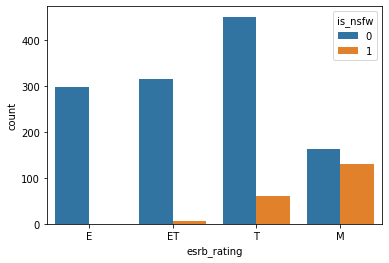

In [12]:
train['is_nsfw'] = train.strong_sexual_content | train.sexual_themes | train.sexual_content | train.partial_nudity | train.nudity
test['is_nsfw'] = test.strong_sexual_content | test.sexual_themes | test.sexual_content | test.partial_nudity | test.nudity
sns.countplot(data = train, x = 'esrb_rating', hue = 'is_nsfw')

* And now we combine all columns with blood keyword

<AxesSubplot:xlabel='esrb_rating', ylabel='count'>

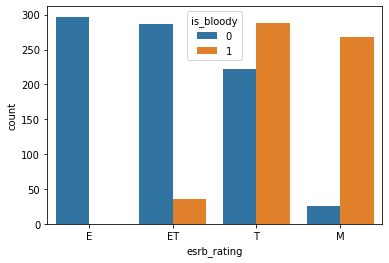

In [13]:
train['is_bloody'] = train.mild_blood | train.blood | train.blood_and_gore
test['is_bloody'] = test.mild_blood | test.blood | test.blood_and_gore
sns.countplot(data = train, x = 'esrb_rating', hue = 'is_bloody')

* There is not many things that are heavily correlated with "ET" rating but animated or fictional themes seems to be one of the few

* This category will help our "ET" predictions

<AxesSubplot:xlabel='esrb_rating', ylabel='count'>

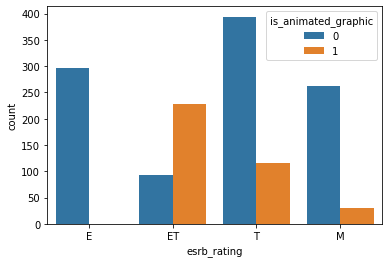

In [14]:
train['is_animated_graphic'] = train.animated_blood | train.fantasy_violence | train.cartoon_violence
test['is_animated_graphic'] = test.animated_blood | test.fantasy_violence | test.cartoon_violence
sns.countplot(data = train, x = 'esrb_rating', hue = 'is_animated_graphic')

* Lets make our features smaller but grouping crude/mature humor

<AxesSubplot:xlabel='esrb_rating', ylabel='count'>

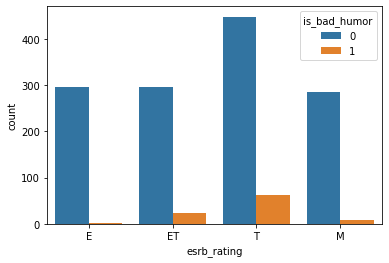

In [15]:
train['is_bad_humor'] = train.crude_humor | train.mature_humor
test['is_bad_humor'] = test.crude_humor | test.mature_humor
sns.countplot(data = train, x = 'esrb_rating', hue = 'is_bad_humor')

* Lets make our features smaller by grouping language/lyrics

<AxesSubplot:xlabel='esrb_rating', ylabel='count'>

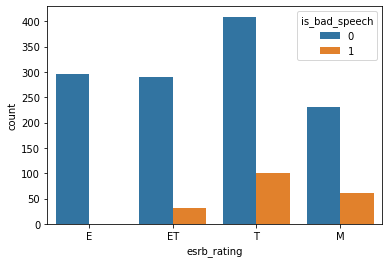

In [16]:
train['is_bad_speech'] = train.language | train.lyrics
test['is_bad_speech'] = test.language | test.lyrics
sns.countplot(data = train, x = 'esrb_rating', hue = 'is_bad_speech')

Now lets drop all columns we used to make our new columns

In [17]:
mg = test['id']
train.drop(['mild_blood', 'mild_cartoon_violence', 'fantasy_violence', 'mild_lyrics', 'mild_suggestive_themes', 'mild_fantasy_violence', 'mild_violence', 'strong_janguage', 'strong_sexual_content', 'use_of_drugs_and_alcohol', 'alcohol_reference', 'sexual_themes', 'sexual_content', 'partial_nudity', 'nudity', 'blood', 'animated_blood', 'id', 'console', 'cartoon_violence', 'drug_reference', 'mild_language', 'title', 'crude_humor', 'mature_humor', 'language', 'lyrics'], axis = 1, inplace = True)
test.drop(['mild_blood', 'mild_cartoon_violence', 'fantasy_violence', 'mild_lyrics', 'mild_suggestive_themes', 'mild_fantasy_violence', 'mild_violence', 'strong_janguage', 'strong_sexual_content', 'use_of_drugs_and_alcohol', 'alcohol_reference', 'sexual_themes', 'sexual_content', 'partial_nudity', 'nudity', 'blood', 'animated_blood', 'id', 'console', 'cartoon_violence', 'drug_reference', 'mild_language', 'crude_humor', 'mature_humor', 'language', 'lyrics'], axis = 1, inplace = True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   blood_and_gore       1421 non-null   int64 
 1   intense_violence     1421 non-null   int64 
 2   no_descriptors       1421 non-null   int64 
 3   simulated_gambling   1421 non-null   int64 
 4   suggestive_themes    1421 non-null   int64 
 5   use_of_alcohol       1421 non-null   int64 
 6   violence             1421 non-null   int64 
 7   esrb_rating          1421 non-null   object
 8   is_mild              1421 non-null   int64 
 9   is_strong            1421 non-null   int64 
 10  is_violent           1421 non-null   int64 
 11  is_drug              1421 non-null   int64 
 12  is_nsfw              1421 non-null   int64 
 13  is_bloody            1421 non-null   int64 
 14  is_animated_graphic  1421 non-null   int64 
 15  is_bad_humor         1421 non-null   int64 
 16  is_bad

In [18]:
print(train.shape)
print(test.shape)

(1421, 17)
(474, 16)


* We will now split our training data and make our train/test data 80/20

* We drop our esrb rating for our X and keep only our esrb rating for our y to make sure we predict accurately

In [19]:
y = train['esrb_rating']
X = train.drop(columns = ['esrb_rating'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 123)
print(y.value_counts())

T     510
ET    321
E     297
M     293
Name: esrb_rating, dtype: int64


* Below we made our models and fit them with our data. We print out our score and a confusion matrix

* The multilabel confusion matrix lets us know our "True Negatives" (@00), " False Positives" (@01), "False Negatives" (@10), "True Positives" (@11)

* I will look at False Negative and False Positives of each to see which esrb rating has a higher rate of bad predictions

# LOGISTIC REGRESSION
* Since logistic regression model does not necessarily have super impactful/important parameters we will  not do any hyperparameter searches

In [20]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_predlr = lr.predict(X_test)
scorelr = lr.score(X_test, y_test)
print(scorelr)
print(multilabel_confusion_matrix(y_test, y_predlr))

0.856140350877193
[[[209   9]
  [  3  64]]

 [[219   9]
  [ 12  45]]

 [[219   4]
  [ 12  50]]

 [[167  19]
  [ 14  85]]]


             CVS
count  20.000000
mean    0.815930
std     0.035452
min     0.750000
25%     0.789474
50%     0.814223
75%     0.842105
max     0.877193


(array([1., 2., 1., 3., 3., 3., 0., 4., 1., 2.]),
 array([0.75      , 0.7627193 , 0.7754386 , 0.78815789, 0.80087719,
        0.81359649, 0.82631579, 0.83903509, 0.85175439, 0.86447368,
        0.87719298]),
 <BarContainer object of 10 artists>)

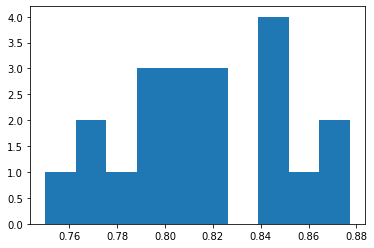

In [21]:
lr_scores = cross_val_score(lr,X_train, y_train, cv = 20)
lr_scoresdf = pd.DataFrame(lr_scores, columns = ['CVS'])
print(lr_scoresdf.describe())
plt.hist(lr_scoresdf['CVS'])

# SUPPORT VECTOR MACHINE
* Hyperparameter search: Kernel & Penalty(C)

In [22]:
clf =  svm.SVC(C = 1, kernel = 'rbf')
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
grid = dict(kernel = kernel,C = C,gamma =['scale'])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator = clf, param_grid = grid, n_jobs = -1, cv = cv, scoring='accuracy',error_score = 0)
grid_result = grid_search.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
clf.fit(X_train, y_train)
y_predsvm = clf.predict(X_test)
scoresvm = clf.score(X_test, y_test)
print(scoresvm)
print(multilabel_confusion_matrix(y_test, y_predsvm))

Best: 0.839300 using {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.8701754385964913
[[[210   8]
  [  0  67]]

 [[223   5]
  [ 13  44]]

 [[219   4]
  [ 12  50]]

 [[166  20]
  [ 12  87]]]


             CVS
count  20.000000
mean    0.815930
std     0.035452
min     0.750000
25%     0.789474
50%     0.814223
75%     0.842105
max     0.877193


(array([1., 2., 1., 3., 3., 3., 0., 4., 1., 2.]),
 array([0.75      , 0.7627193 , 0.7754386 , 0.78815789, 0.80087719,
        0.81359649, 0.82631579, 0.83903509, 0.85175439, 0.86447368,
        0.87719298]),
 <BarContainer object of 10 artists>)

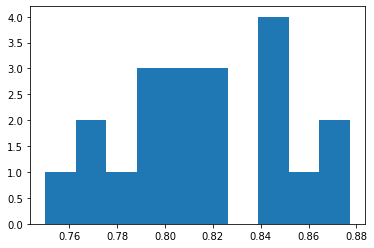

In [23]:
svm_scores = cross_val_score(clf,X_train, y_train, cv = 20)
svm_scoresdf = pd.DataFrame(svm_scores, columns = ['CVS'])
print(lr_scoresdf.describe())
plt.hist(lr_scoresdf['CVS'])

# DECISION TREE CLASSIFIER
* Hyperparameter search: max_depth

In [24]:
dtc =  tree.DecisionTreeClassifier(max_depth = 20)


params = {'max_depth': [2, 3, 5, 10, 20]}
grid_search = GridSearchCV(estimator = dtc, param_grid = params, n_jobs = -1, cv = cv, scoring='accuracy',error_score = 0)
grid_result = grid_search.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


dtc.fit(X_train, y_train)
y_preddtc = dtc.predict(X_test)
scoredtc = dtc.score(X_test, y_test)
print(scoredtc)
print(multilabel_confusion_matrix(y_test, y_preddtc))

Best: 0.827329 using {'max_depth': 20}
0.8596491228070176
[[[208  10]
  [  1  66]]

 [[222   6]
  [ 11  46]]

 [[218   5]
  [ 10  52]]

 [[167  19]
  [ 18  81]]]


             CVS
count  20.000000
mean    0.800172
std     0.047229
min     0.719298
25%     0.770912
50%     0.807018
75%     0.828242
max     0.877193


(array([2., 2., 0., 3., 2., 3., 3., 2., 1., 2.]),
 array([0.71929825, 0.73508772, 0.75087719, 0.76666667, 0.78245614,
        0.79824561, 0.81403509, 0.82982456, 0.84561404, 0.86140351,
        0.87719298]),
 <BarContainer object of 10 artists>)

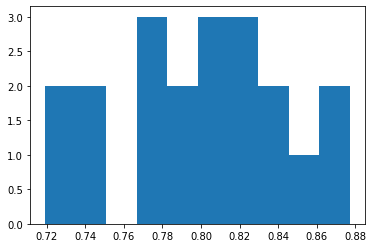

In [25]:
dtc_scores = cross_val_score(dtc,X_train, y_train, cv = 20)
dtc_scoresdf = pd.DataFrame(dtc_scores, columns = ['CVS'])
print(dtc_scoresdf.describe())
plt.hist(dtc_scoresdf['CVS'])

# RANDOM FOREST CLASSIFIER
* Hyperparameter search: n_estimators, max_features, max_depth

In [26]:
rf =  RandomForestClassifier(max_features = 2, n_estimators = 1600, max_depth = 50)



random_grid = {'n_estimators': [20, 200, 400, 1000, 1600, 2000],
               'max_features': [2,3,10],
               'max_depth': [50, 70, 100, 120]}
grid_search = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_result = grid_search.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


rf.fit(X_train, y_train)
y_predrf = rf.predict(X_test)
scorerf = rf.score(X_test, y_test)
print(scorerf)
print(multilabel_confusion_matrix(y_test, y_predrf))

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  1.9min


[CV] max_depth=50, max_features=2, n_estimators=20 ...................
[CV] .... max_depth=50, max_features=2, n_estimators=20, total=   0.1s
[CV] max_depth=50, max_features=2, n_estimators=200 ..................
[CV] ... max_depth=50, max_features=2, n_estimators=200, total=   0.6s
[CV] max_depth=50, max_features=2, n_estimators=1000 .................
[CV] .. max_depth=50, max_features=2, n_estimators=1000, total=   3.1s
[CV] max_depth=50, max_features=2, n_estimators=1000 .................
[CV] .. max_depth=50, max_features=2, n_estimators=1000, total=   3.2s
[CV] max_depth=50, max_features=3, n_estimators=20 ...................
[CV] .... max_depth=50, max_features=3, n_estimators=20, total=   0.1s
[CV] max_depth=50, max_features=3, n_estimators=20 ...................
[CV] .... max_depth=50, max_features=3, n_estimators=20, total=   0.1s
[CV] max_depth=50, max_features=3, n_estimators=20 ...................
[CV] .... max_depth=50, max_features=3, n_estimators=20, total=   0.1s
[CV] m

[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  2.6min finished


Best: 0.840972 using {'max_depth': 70, 'max_features': 2, 'n_estimators': 200}
0.887719298245614
[[[213   5]
  [  1  66]]

 [[225   3]
  [ 12  45]]

 [[219   4]
  [ 11  51]]

 [[166  20]
  [  8  91]]]


             CVS
count  20.000000
mean    0.818640
std     0.041705
min     0.736842
25%     0.800047
50%     0.824561
75%     0.845865
max     0.894737


(array([2., 1., 1., 1., 3., 4., 3., 4., 0., 1.]),
 array([0.73684211, 0.75263158, 0.76842105, 0.78421053, 0.8       ,
        0.81578947, 0.83157895, 0.84736842, 0.86315789, 0.87894737,
        0.89473684]),
 <BarContainer object of 10 artists>)

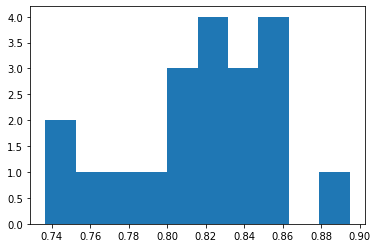

In [27]:
rf_scores = cross_val_score(rf,X_train, y_train, cv = 20)
rf_scoresdf = pd.DataFrame(rf_scores, columns = ['CVS'])
print(rf_scoresdf.describe())
plt.hist(rf_scoresdf['CVS'])

# KNEIGHBORS CLASSIFIER
* Hyperparameter: n_neighbors, leaf_size

In [28]:
kn =  KNeighborsClassifier(n_neighbors = 5, leaf_size = 10)


k_grid = {'n_neighbors': [1, 5, 10, 100],
            'leaf_size': [1,10,20,50]}
grid_search = GridSearchCV(estimator = kn, param_grid = k_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_result = grid_search.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


kn.fit(X_train, y_train)
y_predkn = kn.predict(X_test)
scorekn = kn.score(X_test, y_test)
print(scorekn)
print(multilabel_confusion_matrix(y_test, y_predkn))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best: 0.799455 using {'leaf_size': 10, 'n_neighbors': 5}
0.8491228070175438
[[[207  11]
  [  0  67]]

 [[218  10]
  [ 12  45]]

 [[218   5]
  [ 12  50]]

 [[169  17]
  [ 19  80]]]


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    1.1s finished


             CVS
count  20.000000
mean    0.796570
std     0.038928
min     0.750000
25%     0.767544
50%     0.789474
75%     0.811404
max     0.877193


(array([5., 2., 1., 4., 3., 1., 0., 1., 2., 1.]),
 array([0.75      , 0.7627193 , 0.7754386 , 0.78815789, 0.80087719,
        0.81359649, 0.82631579, 0.83903509, 0.85175439, 0.86447368,
        0.87719298]),
 <BarContainer object of 10 artists>)

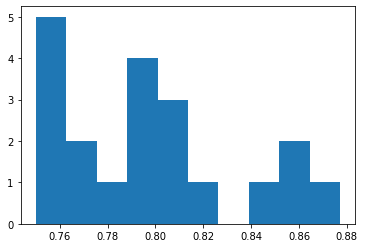

In [29]:
kn_scores = cross_val_score(kn,X_train, y_train, cv = 20)
kn_scoresdf = pd.DataFrame(kn_scores, columns = ['CVS'])
print(kn_scoresdf.describe())
plt.hist(kn_scoresdf['CVS'])

* As I was worried before about not many features to accurately get "ET" ratings it seems to be the rating with the most False Positives/Negatives. Otherwise 85 - 87% is not bad at all

* Our Random Forest Classifier seems to do the best for now so we will use that to predict our test data

In [30]:
my_guess = rf.predict(test)

In [31]:
submission = pd.DataFrame({'id':mg, 'esrb_rating': my_guess})
submission.to_csv('csv_to_submit.csv', index = False)
print('saved file: ' + filename)

saved file: train.csv


In [32]:
print(submission.to_string())

      id esrb_rating
0      0           E
1      1           T
2      2           M
3      3           E
4      4          ET
5      5           M
6      6           T
7      7           E
8      8          ET
9      9          ET
10    10          ET
11    11           T
12    12          ET
13    13           E
14    14           T
15    15           T
16    16           E
17    17           E
18    18           T
19    19           T
20    20          ET
21    21           T
22    22           T
23    23           M
24    24           E
25    25           E
26    26           T
27    27           M
28    28           T
29    29           T
30    30           T
31    31           E
32    32           T
33    33           T
34    34          ET
35    35           T
36    36           E
37    37           E
38    38           T
39    39           T
40    40           E
41    41           E
42    42           T
43    43          ET
44    44           T
45    45           T
46    46     